In [1]:
#Libraries import
import pandas as pd
from mordred import Calculator, descriptors
import mordred
import numpy as np
from rdkit import Chem

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

import joblib

In [2]:
def prepare_data(file):
    
    df = pd.read_excel(file)
    
    try:
        mol_objs = [Chem.MolFromSmiles(smi) for smi in df['SMILES']]
    except:
        mol_objs = [Chem.MolFromSmiles(smi) for smi in df['new_SMILES']]
    
    calculate_descriptors = True
    
    if calculate_descriptors:
        calc = Calculator(descriptors, ignore_3D=True)
        molecular_descriptors = calc.pandas(mol_objs)
        molecular_descriptors = molecular_descriptors.applymap(is_morder_missing)
        molecular_descriptors = molecular_descriptors[sorted(molecular_descriptors.columns)]
    else:
        pass
    print(molecular_descriptors.shape)
    
    simple_preprocessing = True
    if simple_preprocessing:
        molecular_descriptors_cleaned = molecular_descriptors.dropna(axis=1, how='any')
        molecular_descriptors_cleaned
    print(molecular_descriptors_cleaned.shape)
    molecular_descriptors_cleaned = molecular_descriptors_cleaned.loc[:, (molecular_descriptors_cleaned != 0).any(axis=0)]
    print(molecular_descriptors_cleaned.shape)
    
    try:
        molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] = df['Aktywność cytoprotekcyjna [%]']
    except:
        pass
    
    #try:
        #print('Target distribution histogram: ')
        #print(df['Aktywność cytoprotekcyjna [%]'].hist())
    #except:
        #pass
    
    return molecular_descriptors_cleaned

In [3]:
def is_morder_missing(x):
    return np.nan if type(x) == mordred.error.Missing or type(x) == mordred.error.Error else x 

In [4]:
def correlation_dataframe(molecular_descriptors_cleaned, correlation_threshold):
    
    correlation_table = pd.DataFrame(data=molecular_descriptors_cleaned.columns.to_list(), columns=["molecular descriptor name"])
    print(correlation_table.head())
    correlation_to_ak_cyt = []
    for mol_desc in correlation_table['molecular descriptor name']:
        x = np.corrcoef(np.array(molecular_descriptors_cleaned[mol_desc]), np.array(molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]']))
        x = x.tolist()[0][1]
        correlation_to_ak_cyt.append(x)
    correlation_table['corr_value'] = correlation_to_ak_cyt
    print(correlation_table.head())
    correlation_table['absolute correlation value'] = [abs(x) for x in correlation_table['corr_value']]
    print(correlation_table[:-1].head())
    
    mol_desc_best_corr = correlation_table[correlation_table['absolute correlation value'] > correlation_threshold]
    
    print(mol_desc_best_corr.head())
    table_with_descriptors_to_be_used = mol_desc_best_corr[:-1]
    print(table_with_descriptors_to_be_used.head())
    
    #print("Correlation to the target histogram: ")
    #print(correlation_table['absolute correlation value'][:-1].hist(bins=100))
    
    return table_with_descriptors_to_be_used
    

In [5]:
def test_data(molecular_descriptors_cleaned):
    
    test123 = molecular_descriptors_cleaned.loc[(molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] == 90)
                                                | (molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] == 70)
                                        | (molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] == 45)
                                       | (molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] == 10)
                                               | (molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] == 0)]
    
    test_data = test123.iloc[[0, 1, 2, 5, 15]] #It allows to get 5 different points of known activity
    
    return test_data
    

In [6]:
def prepare_model(data, features, test_data):
    
    X = data[features['molecular descriptor name']]
    
    y = data['Aktywność cytoprotekcyjna [%]']
    
    randfor = RandomForestRegressor(random_state=15, n_estimators=20)
    
    randfor.fit(X, y)
    print("Return the coefficient of determination of the prediction: ")
    print(randfor.score(test_data[features['molecular descriptor name']], test_data['Aktywność cytoprotekcyjna [%]']))
    
    pred = randfor.predict(X)
    print("R^2 score: "+ str(r2_score(y, pred)))
    sqrt_r2 = np.sqrt(r2_score(y, pred))
    training_data_r2 = r2_score(y, pred)
    print('Correlation coefficient: '+ str(sqrt_r2))
    print("Test data - unseen during training:")
    pred = randfor.predict(test_data[features['molecular descriptor name']])
    print("R^2 score: "+ str(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]'])))
    sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
    print('Correlation coefficient: '+ str(sqrt_r2))
    print(pred)
    print(test_data['Aktywność cytoprotekcyjna [%]']) 
    test_data_r2 = r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]'])
    

    return randfor, training_data_r2, test_data_r2
    

In [7]:
def data_standarization(dataframe):
    
    dataframe_ = dataframe.drop(['Aktywność cytoprotekcyjna [%]'], axis=1)
    
    to_be_returned = (dataframe_ - dataframe_.mean()) / dataframe_.std()
    to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']
    
    return to_be_returned

In [8]:
def prepare_data_and_create_model(molecular_descriptors_df, correlation_threshold, standarization):
    
    if standarization == True:
        
        print("I am doing standarization...")
        
        data_to_be_prepared = molecular_descriptors_df
        
        stand = data_standarization(data_to_be_prepared)
        
        corr = correlation_dataframe(stand, correlation_threshold)
        
        test_ = test_data(stand)
        
        data_to_be_prepared = stand.drop(test_.index.to_list(), axis=0)
        
        model, train_r2, test_r2 = prepare_model(data_to_be_prepared, corr, test_)
        
    elif standarization == False:
        
        print("I am not doing standarization...")
        
        data_to_be_prepared = molecular_descriptors_df
        
        corr = correlation_dataframe(data_to_be_prepared, correlation_threshold)
        
        test_ = test_data(data_to_be_prepared)
        
        data_to_be_prepared = data_to_be_prepared.drop(test_.index.to_list(), axis=0)
        
        model, train_r2, test_r2 = prepare_model(data_to_be_prepared, corr, test_)
    else:
        print("Error...")
    
    return model, train_r2, test_r2, data_to_be_prepared, corr
    

In [9]:
molecular_descriptors_df = prepare_data('../Data/initial_caffeine.xlsx')

100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 27.80it/s]


(58, 1613)
(58, 1388)
(58, 1137)


In [10]:
without_standarization, train_r2_, test_r2_, hist1, hist2 = prepare_data_and_create_model(molecular_descriptors_df, 0.33, False)

I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8            

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


In [11]:
without_standarization.predict(molecular_descriptors_df[hist2['molecular descriptor name']])

array([19.  , 32.05, 41.65, 19.15, 19.45, 35.45,  8.05,  2.75,  5.75,
       23.15, 70.5 , 54.5 , 63.45, 46.25, 11.8 , 48.5 , 36.  ,  6.75,
       19.75,  5.5 , 12.5 , 16.25,  9.5 ,  0.75,  6.5 , 13.5 , 12.55,
       18.  , 65.  , 44.5 , 32.75, 62.85, 58.45, 31.25, 60.75, 48.9 ,
       61.  , 76.5 , 65.65, 66.25, 73.  , 67.5 , 58.  , 21.65, 25.95,
       18.2 , 34.1 , 43.05, 25.3 , 30.75, 20.45, 27.6 , 33.  , 38.7 ,
        3.7 , 26.2 , 29.  , 28.5 ])

In [12]:
xs = r2_score(without_standarization.predict(molecular_descriptors_df[hist2['molecular descriptor name']]), molecular_descriptors_df['Aktywność cytoprotekcyjna [%]'])

In [13]:
xs

0.6440237341418344

In [14]:
np.sqrt(xs)

0.802510893472378

Target distribution histogram: 
AxesSubplot(0.125,0.11;0.775x0.77)


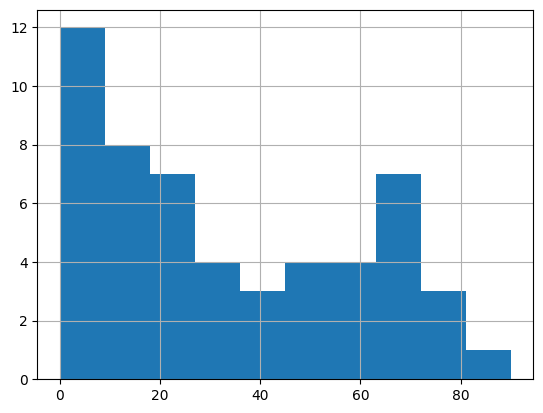

In [15]:
print('Target distribution histogram: ')
print(hist1['Aktywność cytoprotekcyjna [%]'].hist())

In [16]:
print("Number of features (molecular descriptors used): "+ str(len(hist2)))

Number of features (molecular descriptors used): 64


In [17]:
hist2

,molecular descriptor name,corr_value,absolute correlation value
1,AATS0are,0.342320,0.342320
8,AATS0s,0.350131,0.350131
9,AATS0se,0.363989,0.363989
12,AATS1are,0.352396,0.352396
18,AATS1pe,0.338436,0.338436
...,...,...,...
864,SddsN,-0.335349,0.335349
932,SsSH,0.335381,0.335381
936,SssO,0.335389,0.335389
1101,nBondsD,0.369996,0.369996


In [18]:
with_standarization, train_r2__, test_r2__, hist1_, hist2_ = prepare_data_and_create_model(molecular_descriptors_df, 0.33, True)

I am doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                

C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


Return the coefficient of determination of the prediction: 
-0.021705782312925193
R^2 score: 0.912020276650322
Correlation coefficient: 0.9549975270388515
Test data - unseen during training:
R^2 score: -3.6530088418808973
Correlation coefficient: nan
[32.05 19.45 35.45 23.15 65.  ]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64


C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


In [19]:
with_standarization.predict(molecular_descriptors_df[hist2_['molecular descriptor name']])

array([41.1 , 39.35, 40.6 , 41.1 , 41.6 , 42.25, 40.15, 41.4 , 42.25,
       40.1 , 41.5 , 43.9 , 42.25, 42.25, 41.75, 40.4 , 41.75, 41.35,
       40.65, 42.25, 40.65, 41.15, 40.65, 40.4 , 40.4 , 40.65, 40.15,
       41.45, 44.55, 40.35, 41.45, 46.55, 40.35, 41.45, 43.85, 40.35,
       40.35, 44.55, 41.45, 55.15, 54.85, 47.  , 47.  , 41.5 , 42.  ,
       41.45, 44.35, 40.6 , 42.2 , 45.3 , 40.6 , 41.5 , 40.4 , 40.65,
       40.65, 40.4 , 40.4 , 40.4 ])

In [20]:
xs = r2_score(with_standarization.predict(molecular_descriptors_df[hist2_['molecular descriptor name']]), molecular_descriptors_df['Aktywność cytoprotekcyjna [%]'])

In [21]:
xs

-85.02936697678236

## Search inside correlation space

In [22]:
step = 0.01
initial_step = 0.3
last_step = 0.48
first_list = [x / 100.0 for x in range(int(initial_step*100), int(last_step*100), int(step*100))]
second_list = []
third_list = []
f_list = []
for i in first_list:
    without_standarization, train_r2, test_r2, _, h_ = prepare_data_and_create_model(molecular_descriptors_df, i, False)
    second_list.append(train_r2)
    third_list.append(test_r2)
    f_list.append(len(h_))


I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7            

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


Return the coefficient of determination of the prediction: 
-0.05885374149659883
R^2 score: 0.9141103212985847
Correlation coefficient: 0.9560911678802313
Test data - unseen during training:
R^2 score: -11.47752423935132
Correlation coefficient: nan
[38.25 21.65 38.35 25.55 49.5 ]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320       

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


R^2 score: 0.9120556668596541
Correlation coefficient: 0.9550160558124947
Test data - unseen during training:
R^2 score: -3.6530088418808973
Correlation coefficient: nan
[32.05 19.45 35.45 23.15 65.  ]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                   

C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


-0.03664200680272112
R^2 score: 0.911871031081825
Correlation coefficient: 0.9549193845984199
Test data - unseen during training:
R^2 score: -3.903497996513508
Correlation coefficient: nan
[29.85 21.2  38.3  24.8  65.25]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619

C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWa

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
9                    AATS0se    0.363989                    0.363989
20                   AATS1se    0.363608                    0.363608
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89     

C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


Return the coefficient of determination of the prediction: 
-0.16743154761904777
R^2 score: 0.907437076017025
Correlation coefficient: 0.9525949170644492
Test data - unseen during training:
R^2 score: -4.553832020084257
Correlation coefficient: nan
[28.05 11.7  35.05 18.05 57.  ]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320        

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
14

C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


Return the coefficient of determination of the prediction: 
-0.08714795918367346
R^2 score: 0.9113804216656
Correlation coefficient: 0.9546624647830247
Test data - unseen during training:
R^2 score: -5.486615659374112
Correlation coefficient: nan
[36.75 19.45 10.   15.05 47.25]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320          

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145                   AATSC4s   -0.431682                    0.431682
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
53

C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWa

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
646                    MATS1Z   -0.464299                    0.464299
65

C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


In [23]:
df_without_standarization = pd.DataFrame(data=first_list, columns=["Correlation threshold"])

In [24]:
df_without_standarization['Training data R^2 score'] = second_list
df_without_standarization['Test data R^2 score'] = third_list
df_without_standarization['Number of features'] = f_list

In [25]:
df_without_standarization

,Correlation threshold,Training data R^2 score,Test data R^2 score,Number of features
0,0.30,0.914110,-11.477524,87
1,0.31,0.907563,-9.354065,75
2,0.32,0.907325,-8.266373,72
3,0.33,0.912056,-3.653009,64
4,0.34,0.911871,-3.903498,52
5,0.35,0.913106,-4.313837,45
6,0.36,0.923613,-5.065590,38
7,0.37,0.920649,-6.071294,31
8,0.38,0.907437,-4.553832,29
9,0.39,0.915585,-6.498960,23


In [26]:
step = 0.01
initial_step = 0.3
last_step = 0.48
first_list = [x / 100.0 for x in range(int(initial_step*100), int(last_step*100), int(step*100))]
second_list = []
third_list = []
f_list = []
for i in first_list:
    without_standarization, train_r2, test_r2, _, h_ = prepare_data_and_create_model(molecular_descriptors_df, i, True)
    second_list.append(train_r2)
    third_list.append(test_r2)
    f_list.append(len(h_))

I am doing standarization...


C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845      

C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20     

C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20                   AATS1se    0.363608                    0.363608
30     

C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
9                    AATS0se    0.363989                    0.363989
20                   AATS1se    0.363608                    0.363608
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89     

C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
14

C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
35

C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
36

C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145                   AATSC4s   -0.431682                    0.431682
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
53

C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']
C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


Return the coefficient of determination of the prediction: 
0.022310799319727903
R^2 score: 0.8846601395207333
Correlation coefficient: 0.9405637349593771
Test data - unseen during training:
R^2 score: -4.609867306551337
Correlation coefficient: nan
[43.5  11.   16.   20.2  45.15]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i


C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
1137  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
    molecular descriptor name  corr_value  absol

C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


In [27]:
df_with_standarization = pd.DataFrame(data=first_list, columns=["Correlation threshold"])
df_with_standarization['Training data R^2 score'] = second_list
df_with_standarization['Test data R^2 score'] = third_list
df_with_standarization['Number of features'] = f_list

In [28]:
df_with_standarization

,Correlation threshold,Training data R^2 score,Test data R^2 score,Number of features
0,0.30,0.914013,-11.477524,87
1,0.31,0.908013,-9.635208,75
2,0.32,0.906671,-9.563907,72
3,0.33,0.912020,-3.653009,64
4,0.34,0.911907,-3.929836,52
5,0.35,0.912731,-4.350931,45
6,0.36,0.922940,-5.111201,38
7,0.37,0.920956,-6.071294,31
8,0.38,0.907481,-4.553832,29
9,0.39,0.916060,-6.498960,23


## Plots

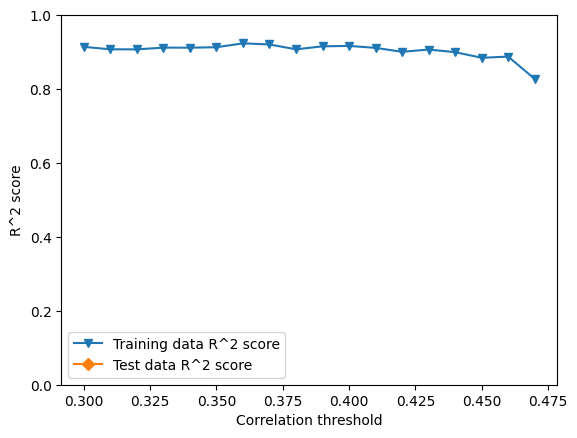

In [29]:
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['Training data R^2 score'], label = "Training data R^2 score", marker='v')
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['Test data R^2 score'], label = "Test data R^2 score", marker='D')
plt.legend()
plt.xlabel('Correlation threshold')
plt.ylabel('R^2 score')
plt.ylim([0, 1])
plt.show()

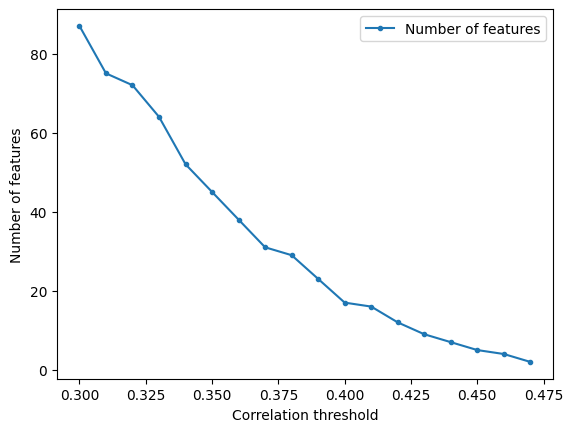

In [30]:
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['Number of features'], label = "Number of features", marker='.')
plt.legend()
plt.xlabel('Correlation threshold')
plt.ylabel('Number of features')
plt.show()

# sqrt(R^2)

In [31]:
df_without_standarization['train R value'] = [np.sqrt(x) for x in df_without_standarization['Training data R^2 score']]

In [32]:
df_without_standarization

,Correlation threshold,Training data R^2 score,Test data R^2 score,Number of features,train R value
0,0.30,0.914110,-11.477524,87,0.956091
1,0.31,0.907563,-9.354065,75,0.952661
2,0.32,0.907325,-8.266373,72,0.952536
3,0.33,0.912056,-3.653009,64,0.955016
4,0.34,0.911871,-3.903498,52,0.954919
5,0.35,0.913106,-4.313837,45,0.955566
6,0.36,0.923613,-5.065590,38,0.961048
7,0.37,0.920649,-6.071294,31,0.959505
8,0.38,0.907437,-4.553832,29,0.952595
9,0.39,0.915585,-6.498960,23,0.956862


In [33]:
xcz = []
for element in df_without_standarization['Test data R^2 score']:
    x = np.sqrt(element)
    try:
        if x > 0:
            xcz.append(x)
        else:
            xcz.append(0)
    except:
        pass
    

C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\2727130492.py:3: RuntimeWarning: invalid value encountered in sqrt
  x = np.sqrt(element)


In [34]:
xcz

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [35]:
df_without_standarization['test R value'] = xcz

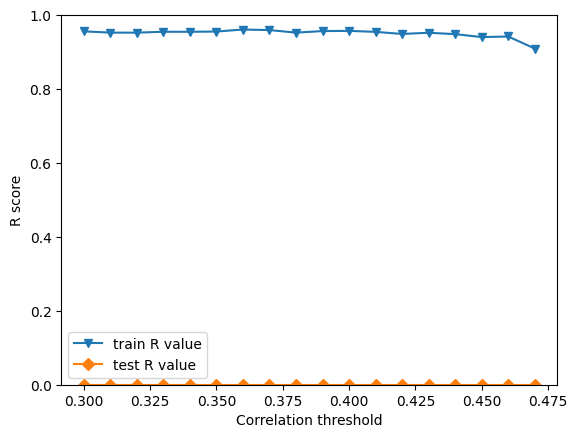

In [36]:
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['train R value'], label = "train R value", marker='v')
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['test R value'], label = "test R value", marker='D')
plt.legend()
plt.xlabel('Correlation threshold')
plt.ylabel('R score')
plt.ylim([0, 1])
plt.show()

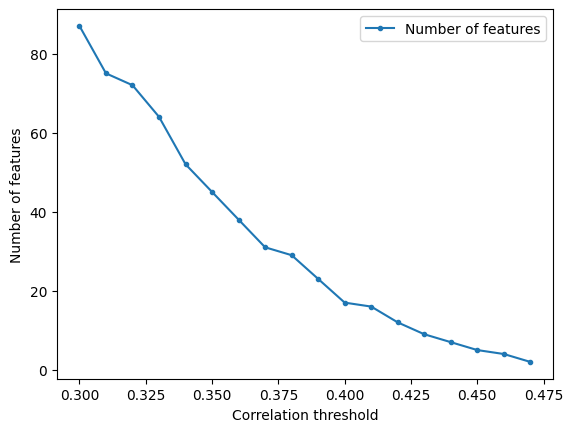

In [37]:
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['Number of features'], label = "Number of features", marker='.')
plt.legend()
plt.xlabel('Correlation threshold')
plt.ylabel('Number of features')
plt.show()

## Final model

In [38]:
final_model = prepare_data_and_create_model(molecular_descriptors_df, 0.43, False)

I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145        

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_6544\3504235137.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


In [39]:
final_model[0].estimators_

[DecisionTreeRegressor(max_features=1.0, random_state=1498160584),
 DecisionTreeRegressor(max_features=1.0, random_state=1346817781),
 DecisionTreeRegressor(max_features=1.0, random_state=768352140),
 DecisionTreeRegressor(max_features=1.0, random_state=392366725),
 DecisionTreeRegressor(max_features=1.0, random_state=233488247),
 DecisionTreeRegressor(max_features=1.0, random_state=476682624),
 DecisionTreeRegressor(max_features=1.0, random_state=1552795804),
 DecisionTreeRegressor(max_features=1.0, random_state=1368427163),
 DecisionTreeRegressor(max_features=1.0, random_state=1182837959),
 DecisionTreeRegressor(max_features=1.0, random_state=1832416971),
 DecisionTreeRegressor(max_features=1.0, random_state=128850005),
 DecisionTreeRegressor(max_features=1.0, random_state=107172470),
 DecisionTreeRegressor(max_features=1.0, random_state=1313911727),
 DecisionTreeRegressor(max_features=1.0, random_state=1384259805),
 DecisionTreeRegressor(max_features=1.0, random_state=1307707409),
 

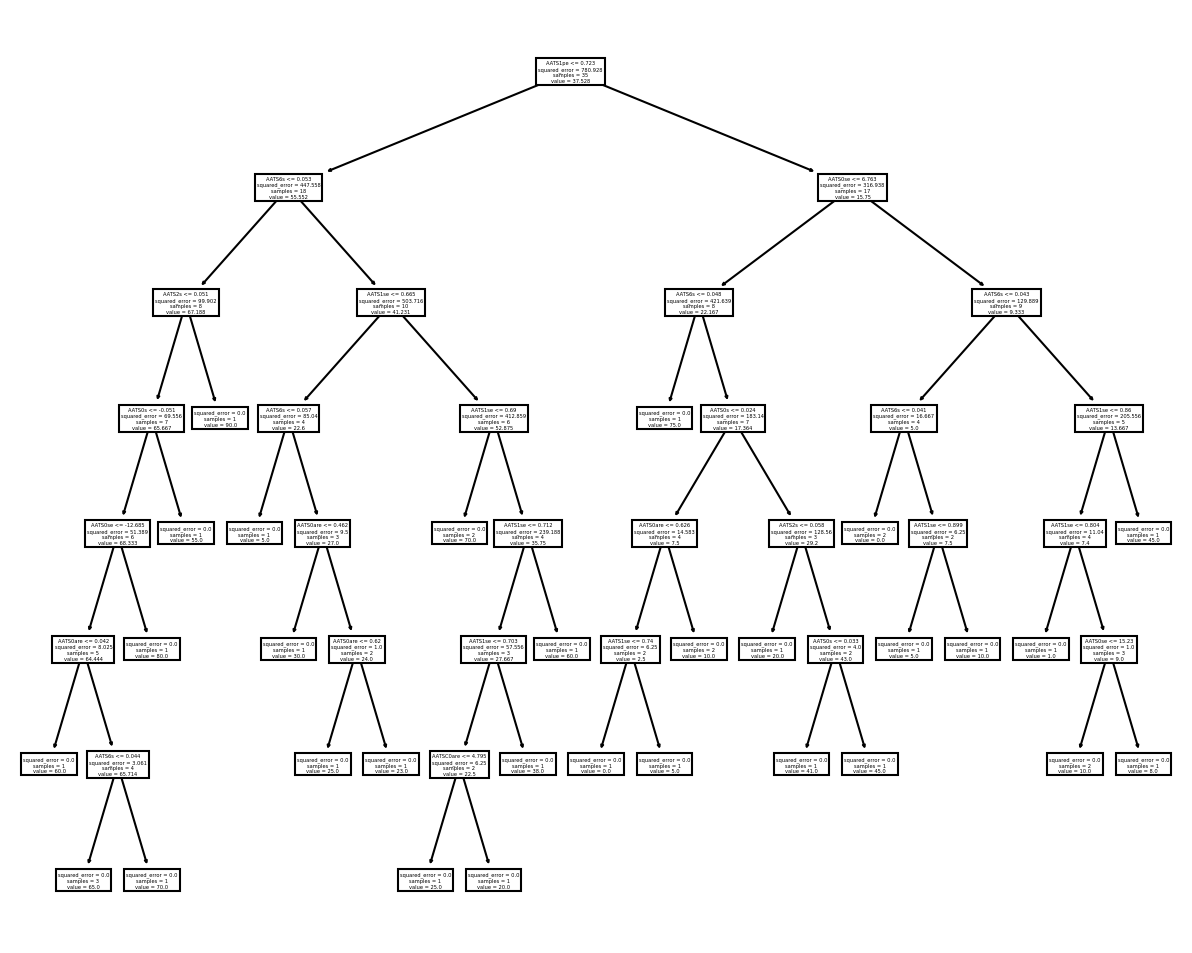

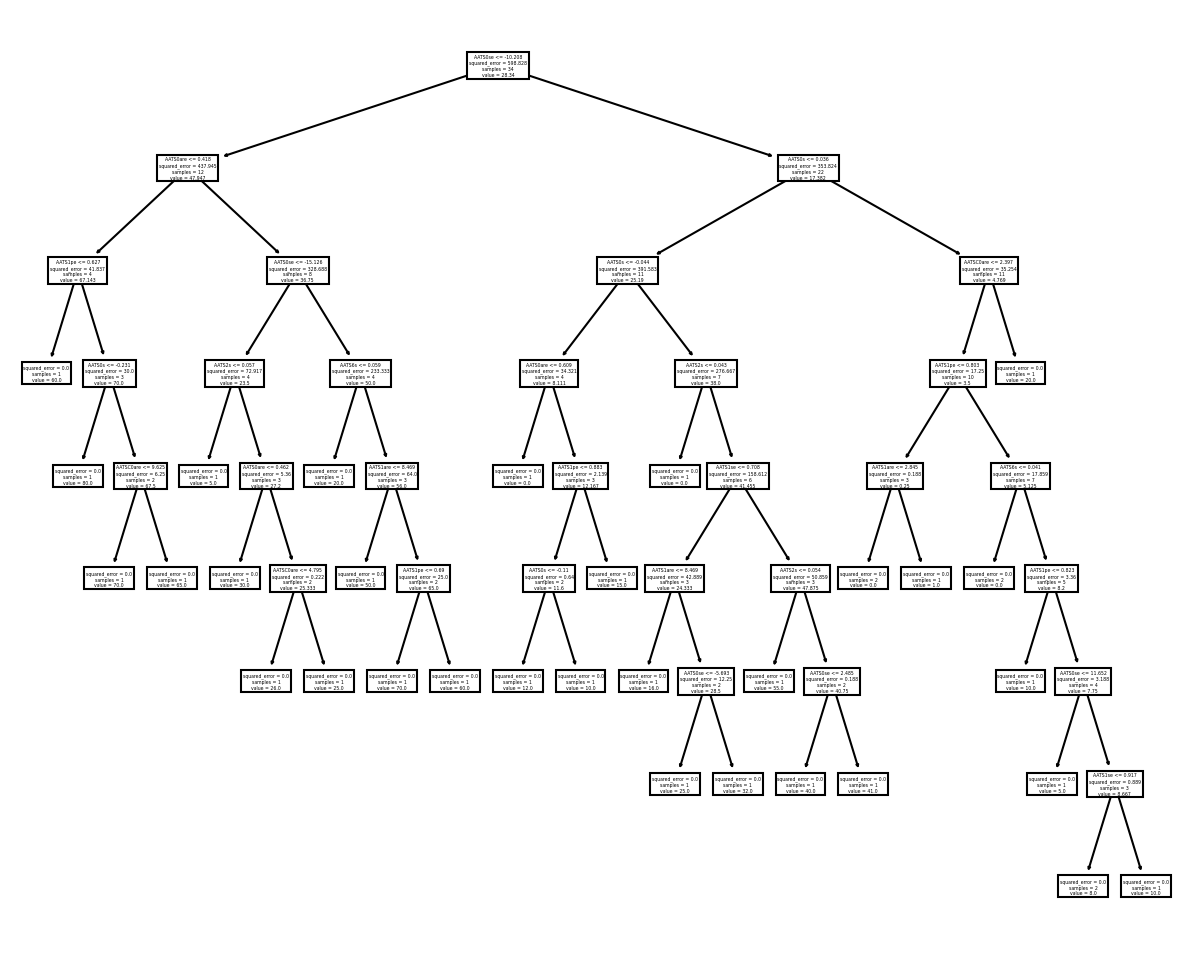

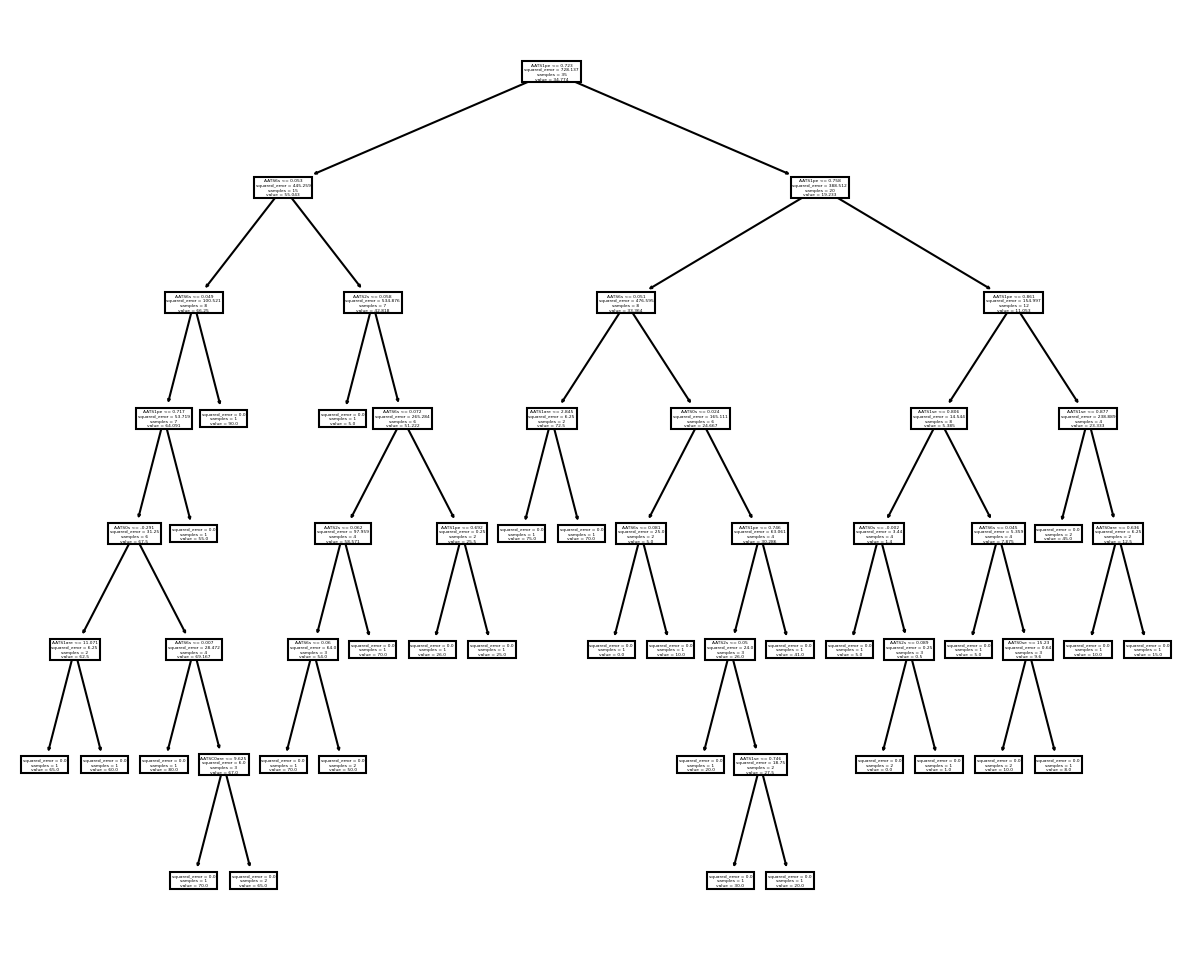

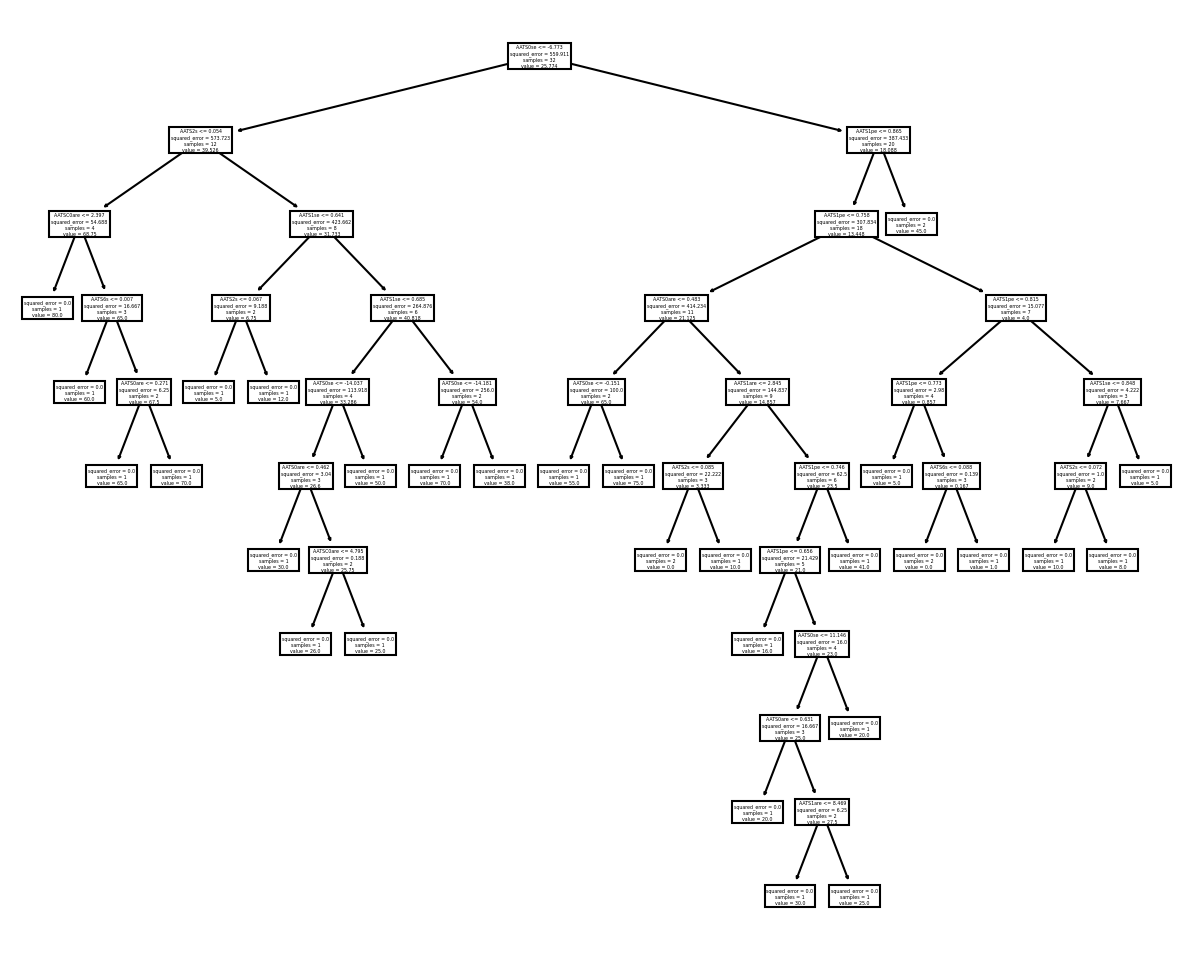

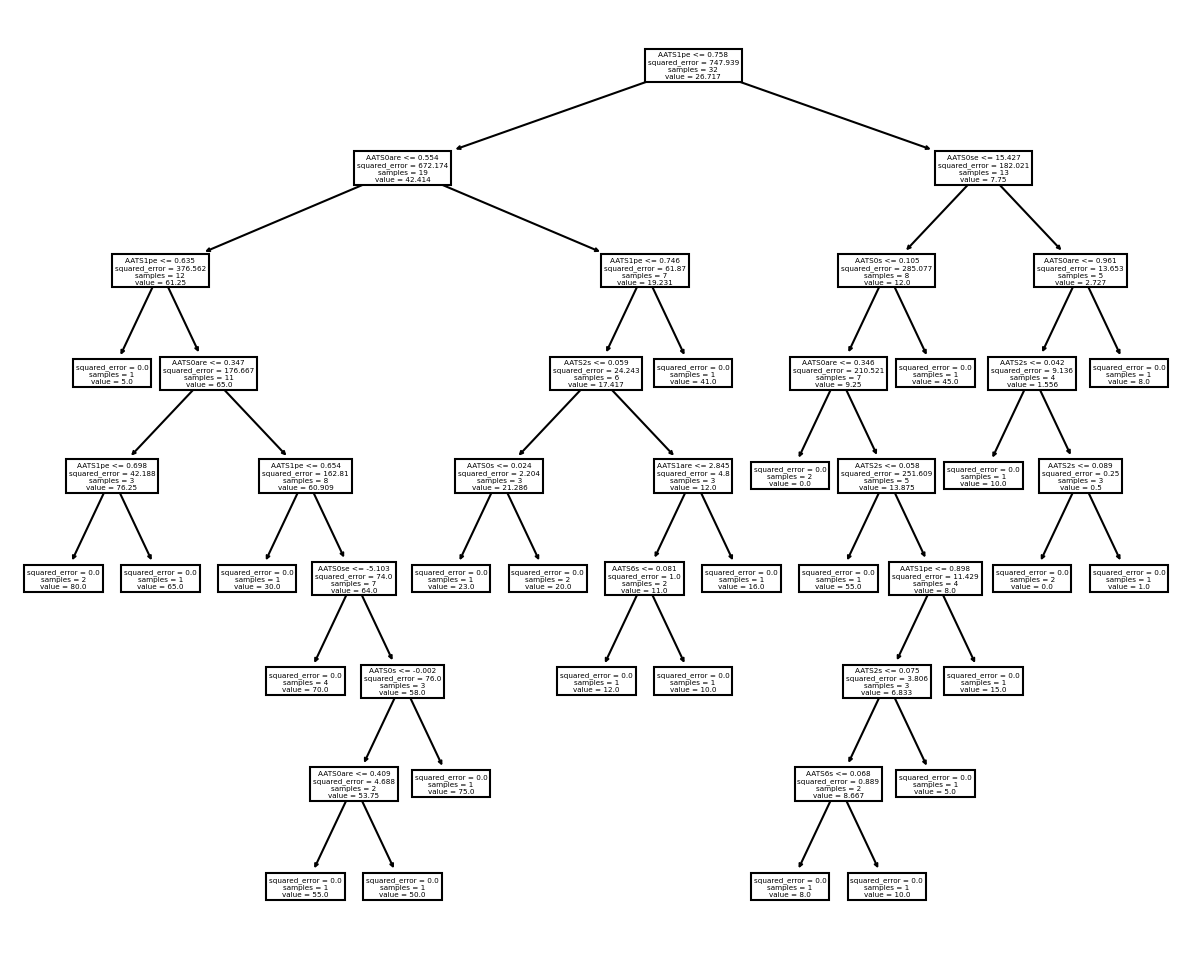

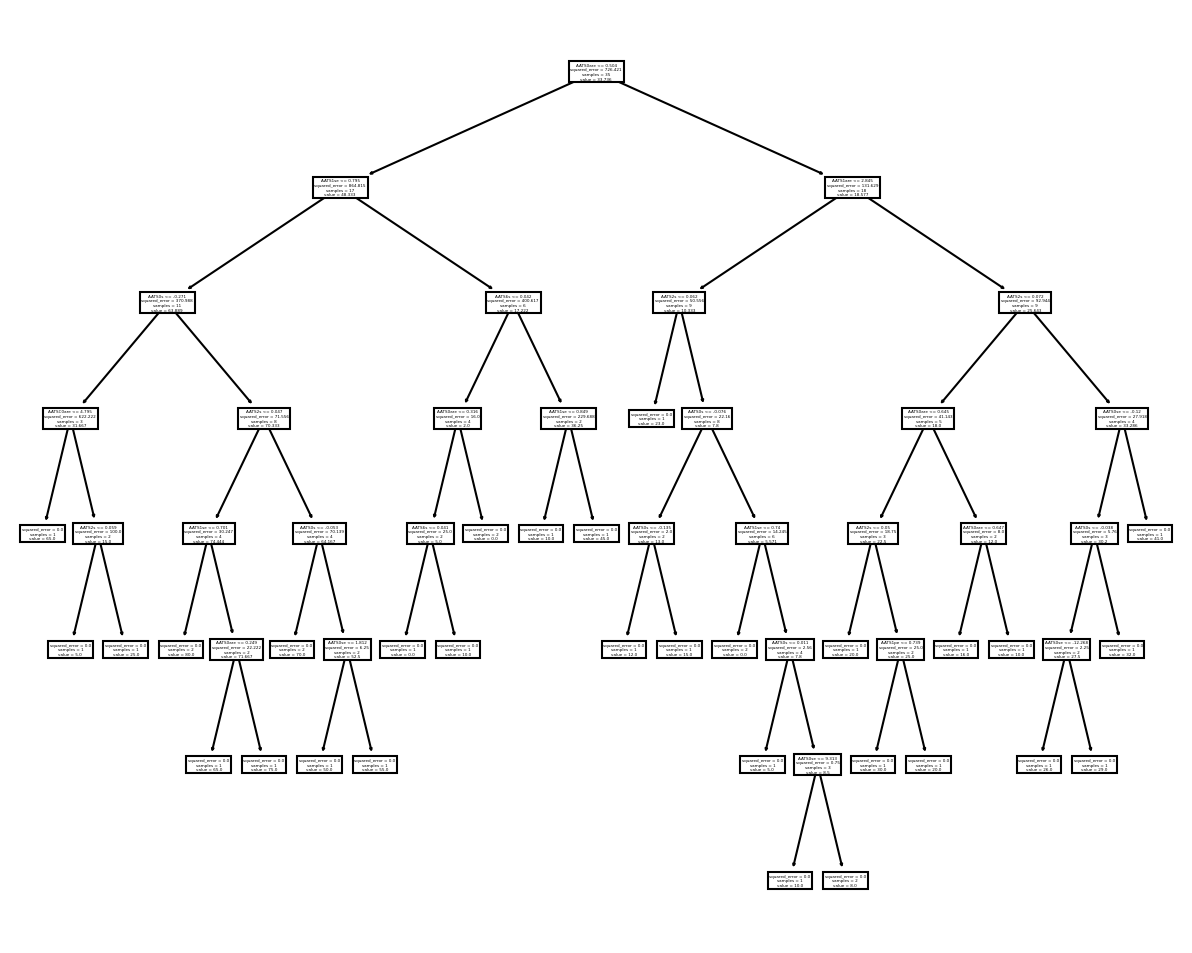

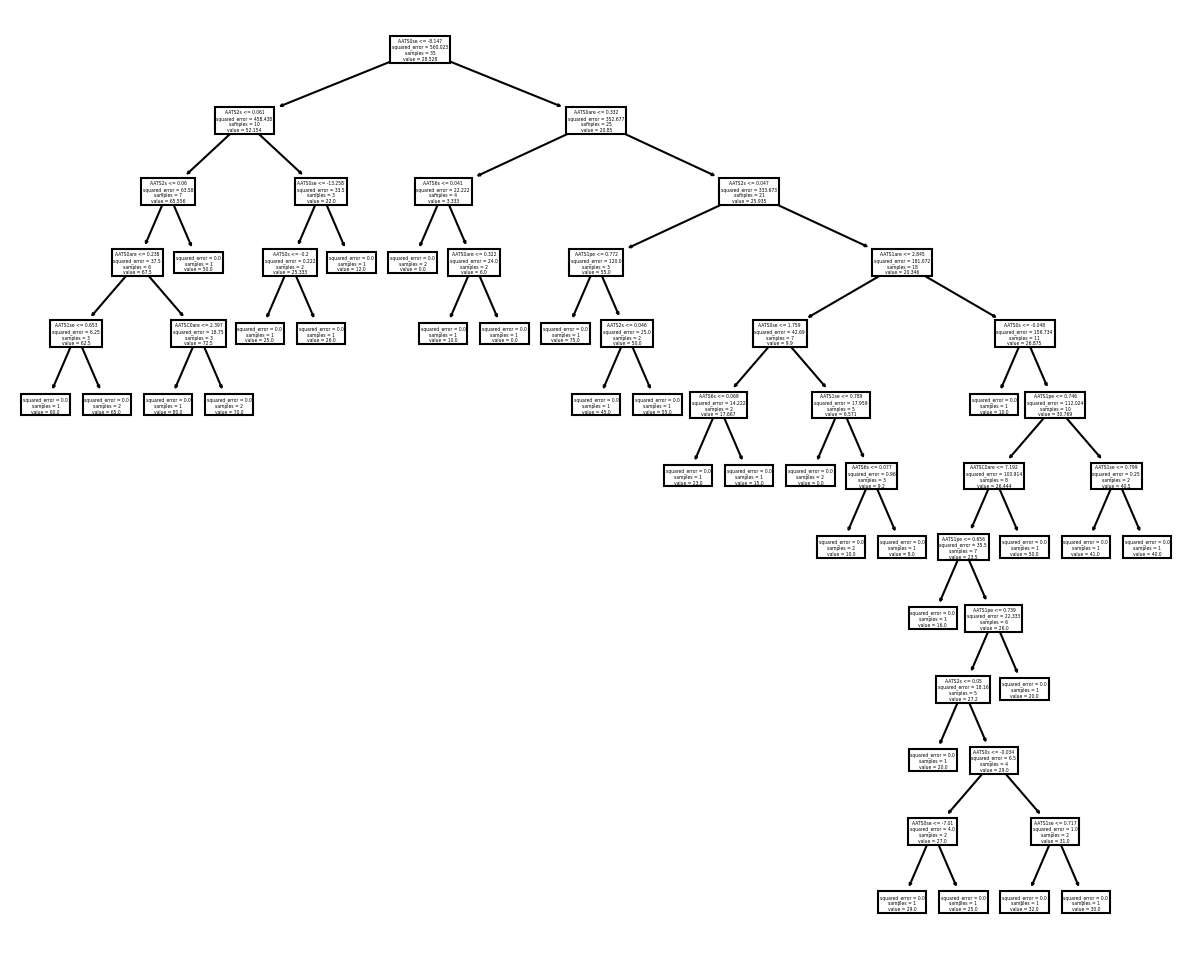

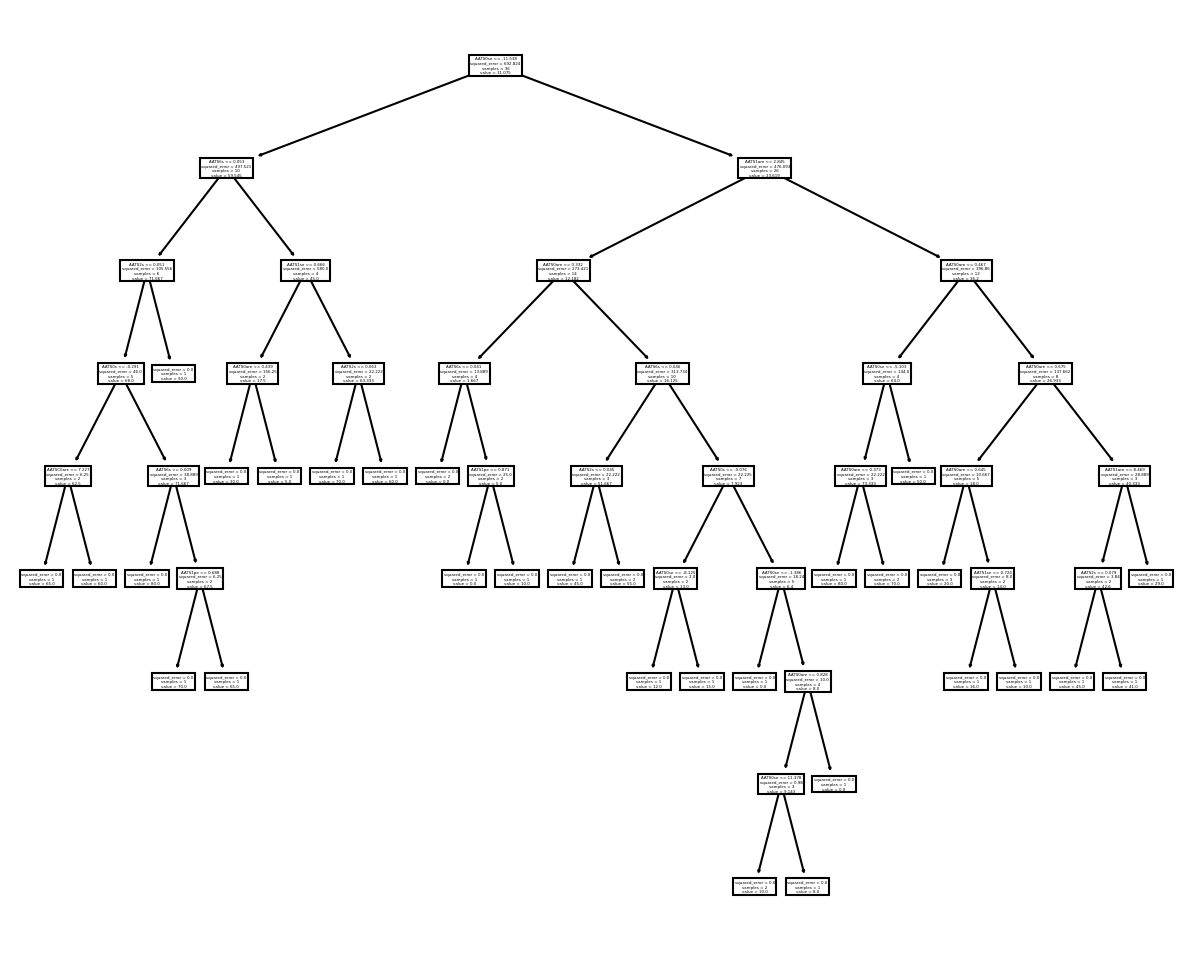

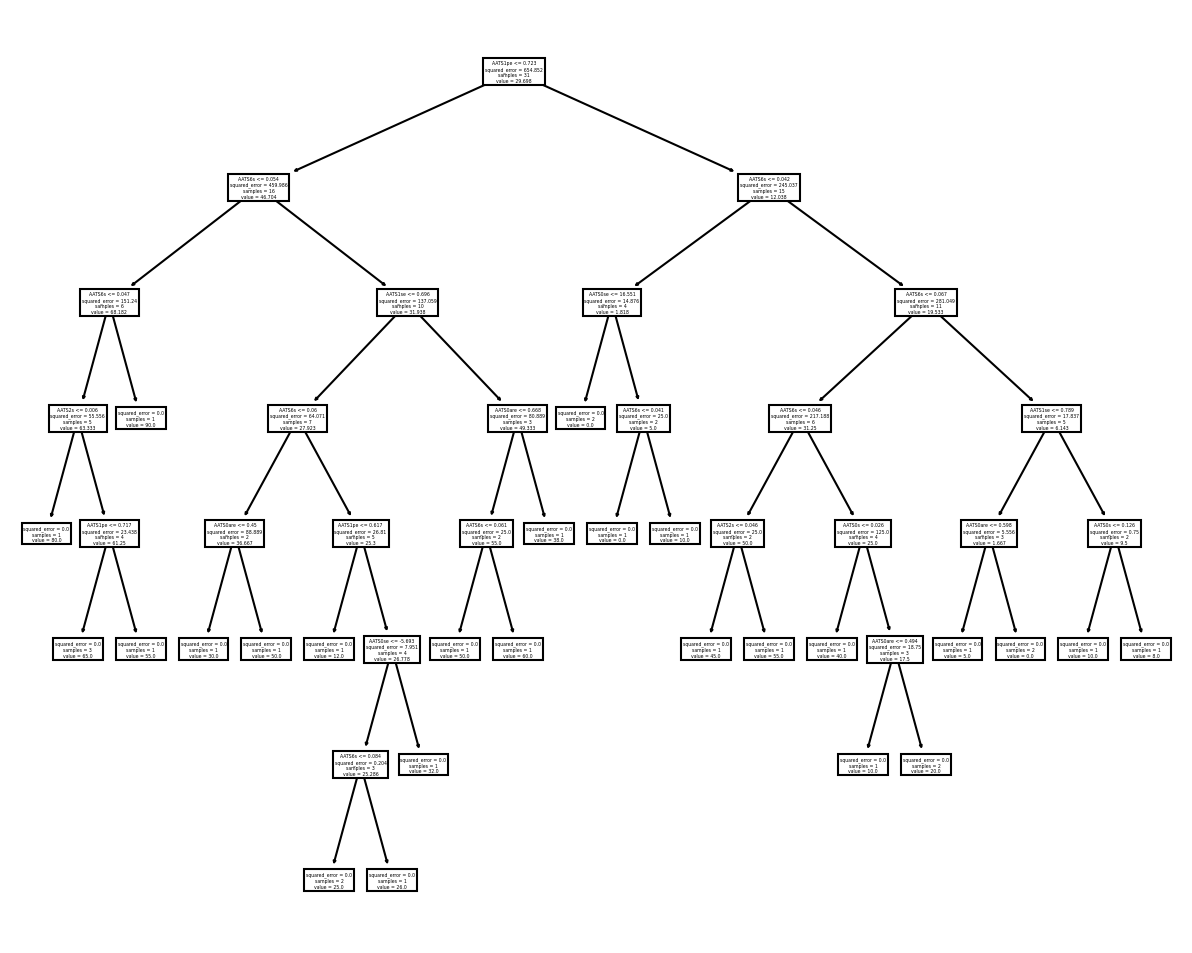

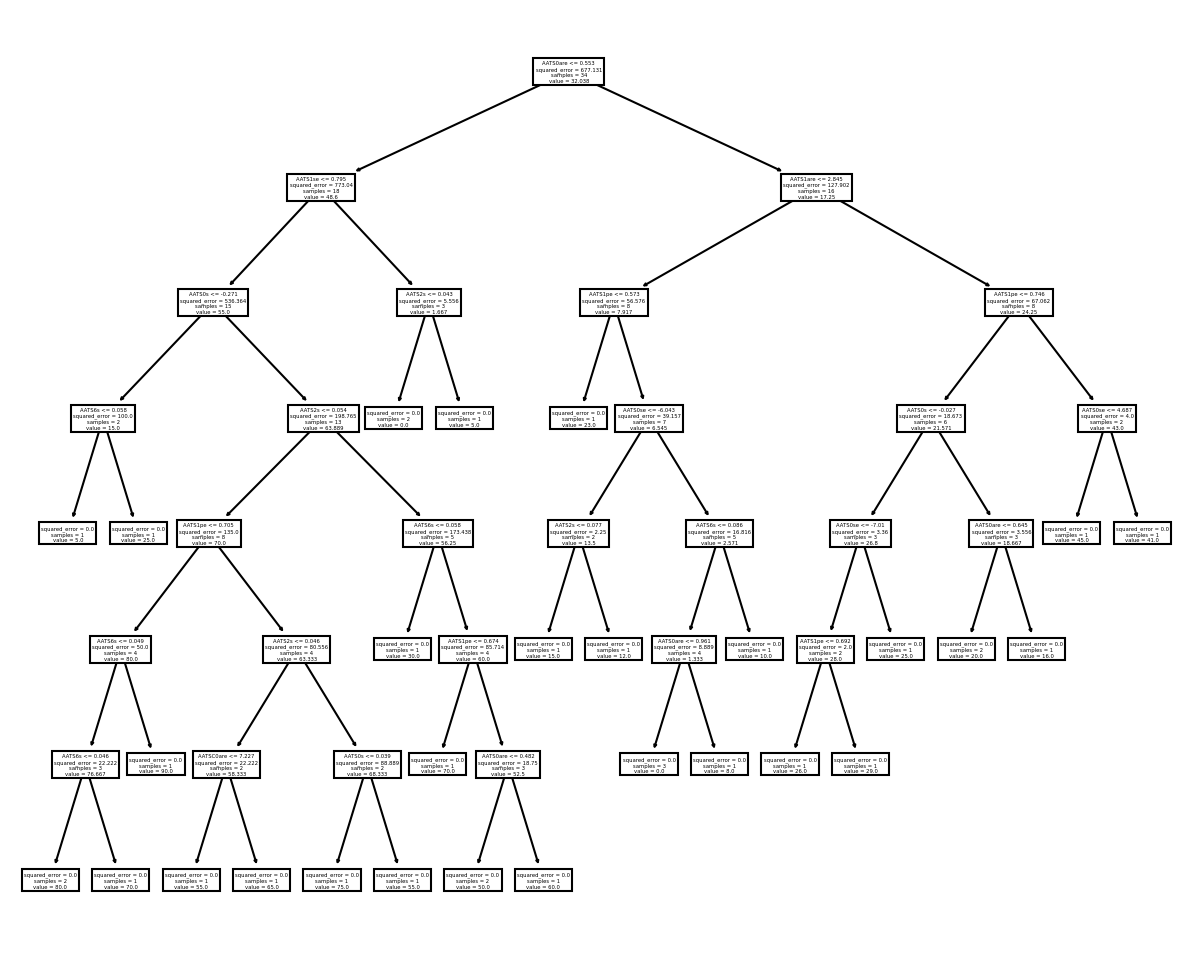

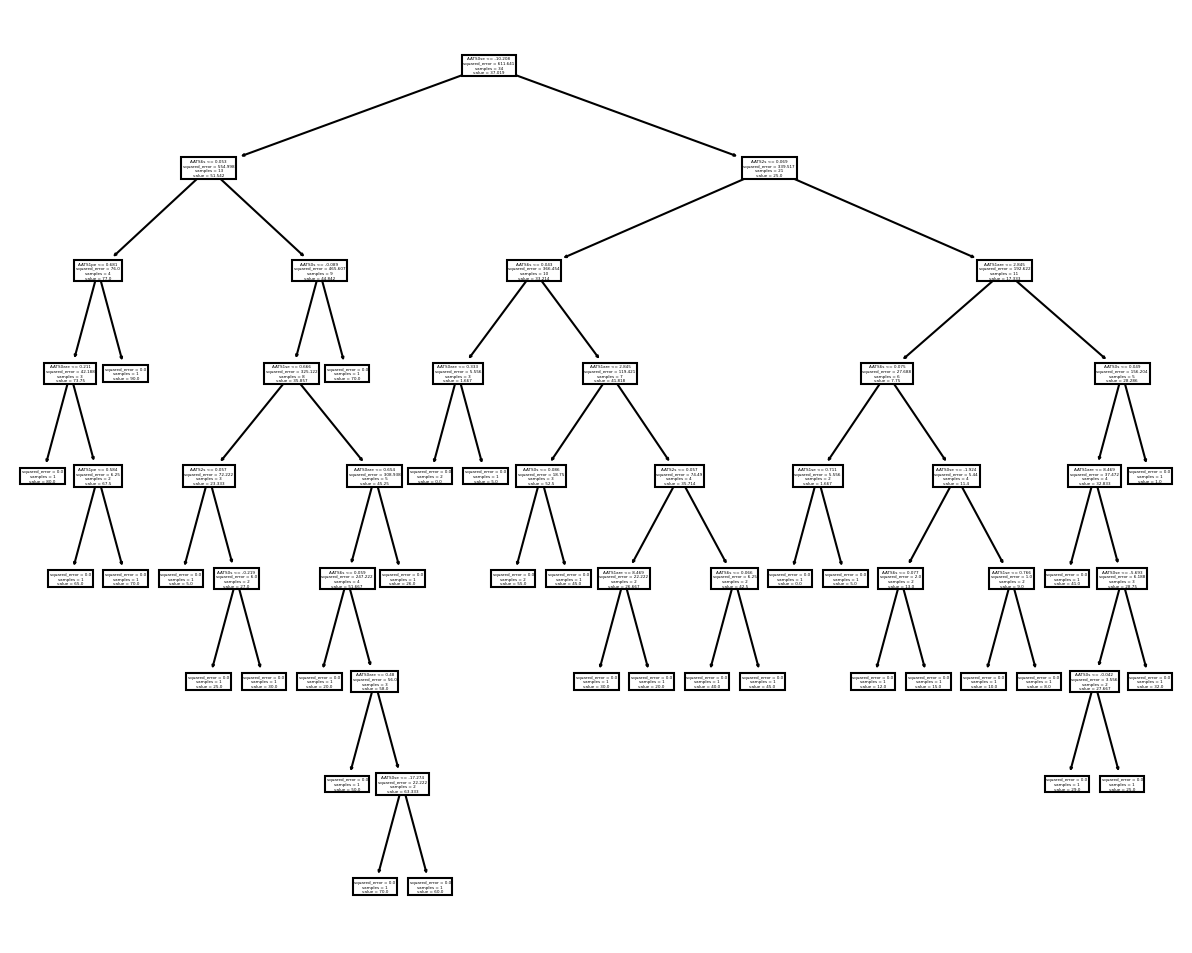

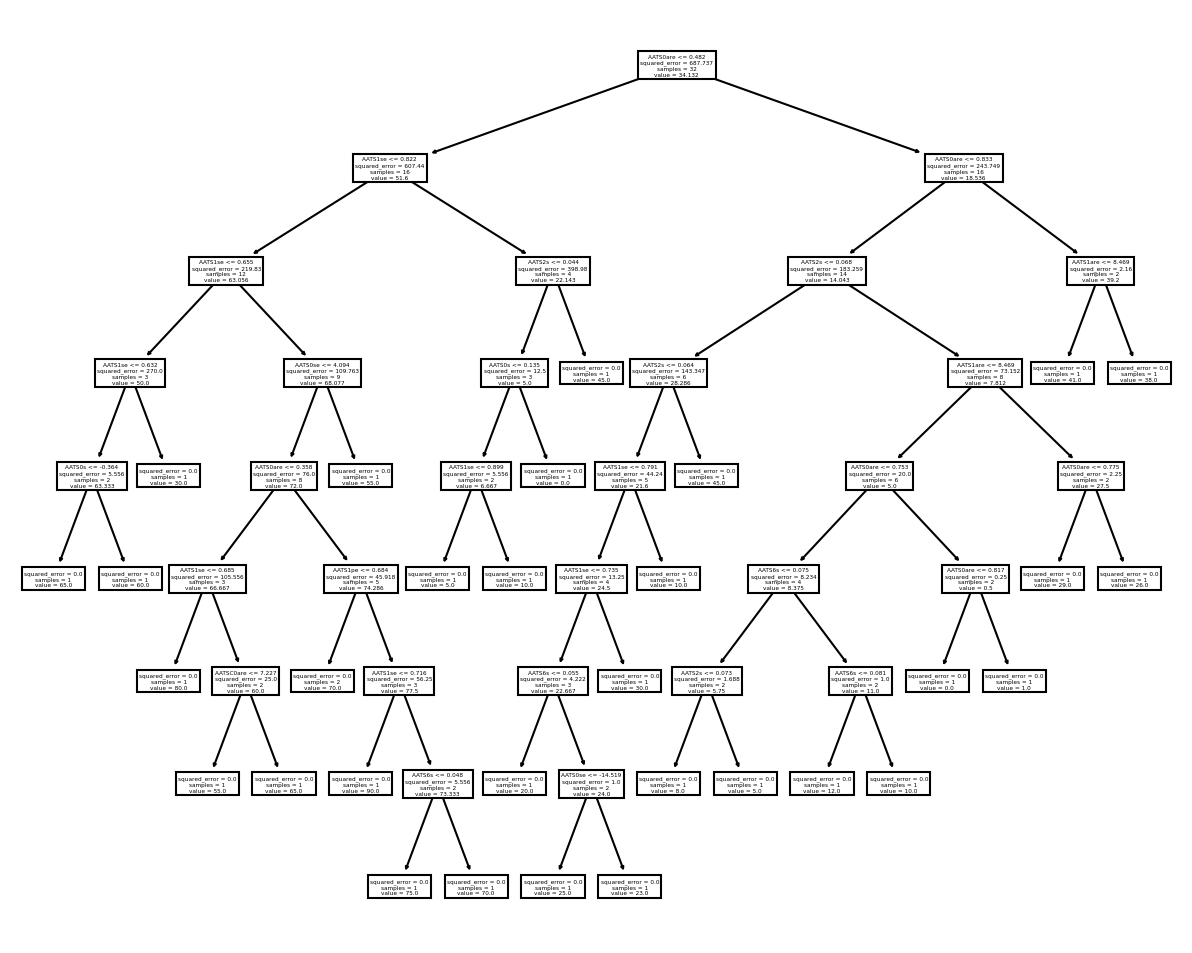

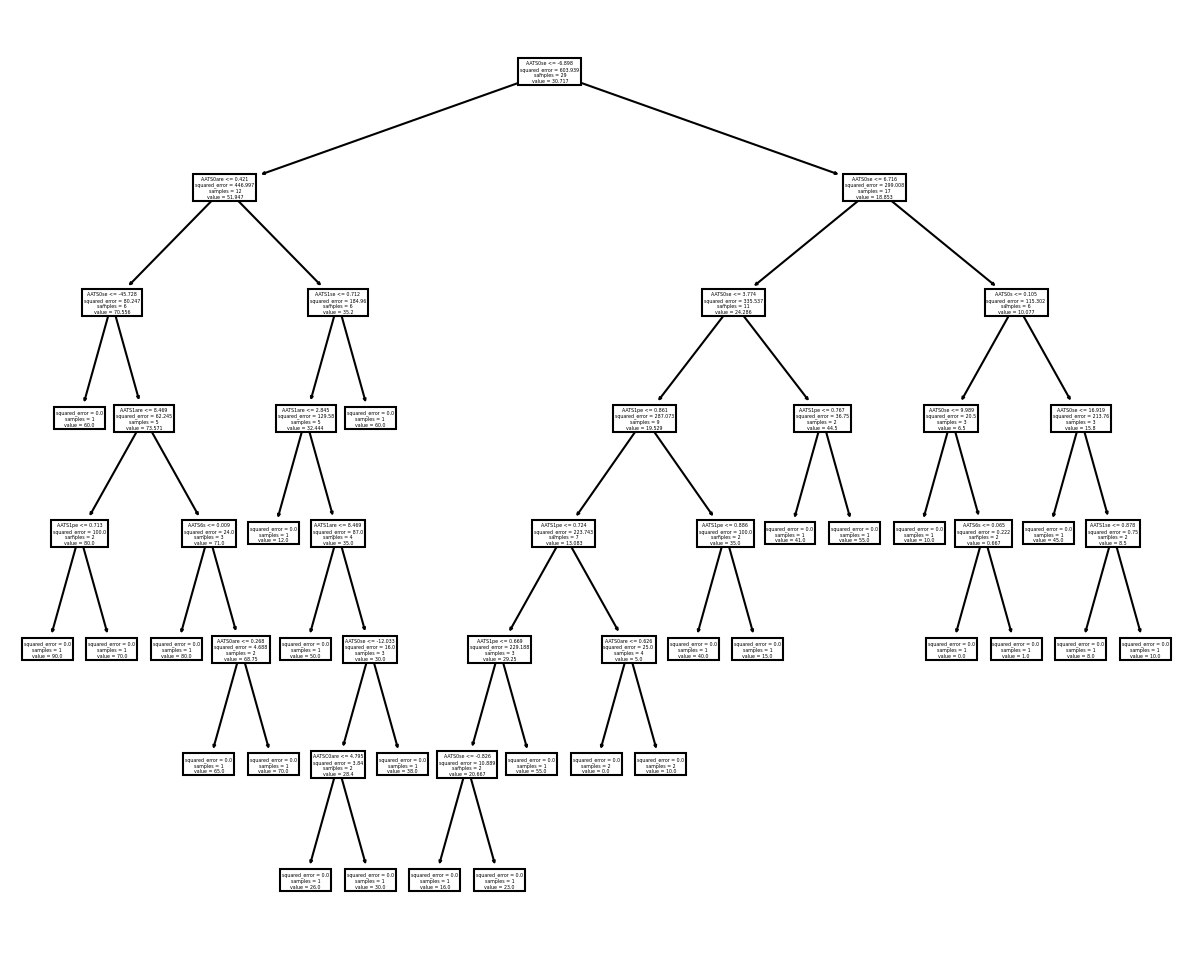

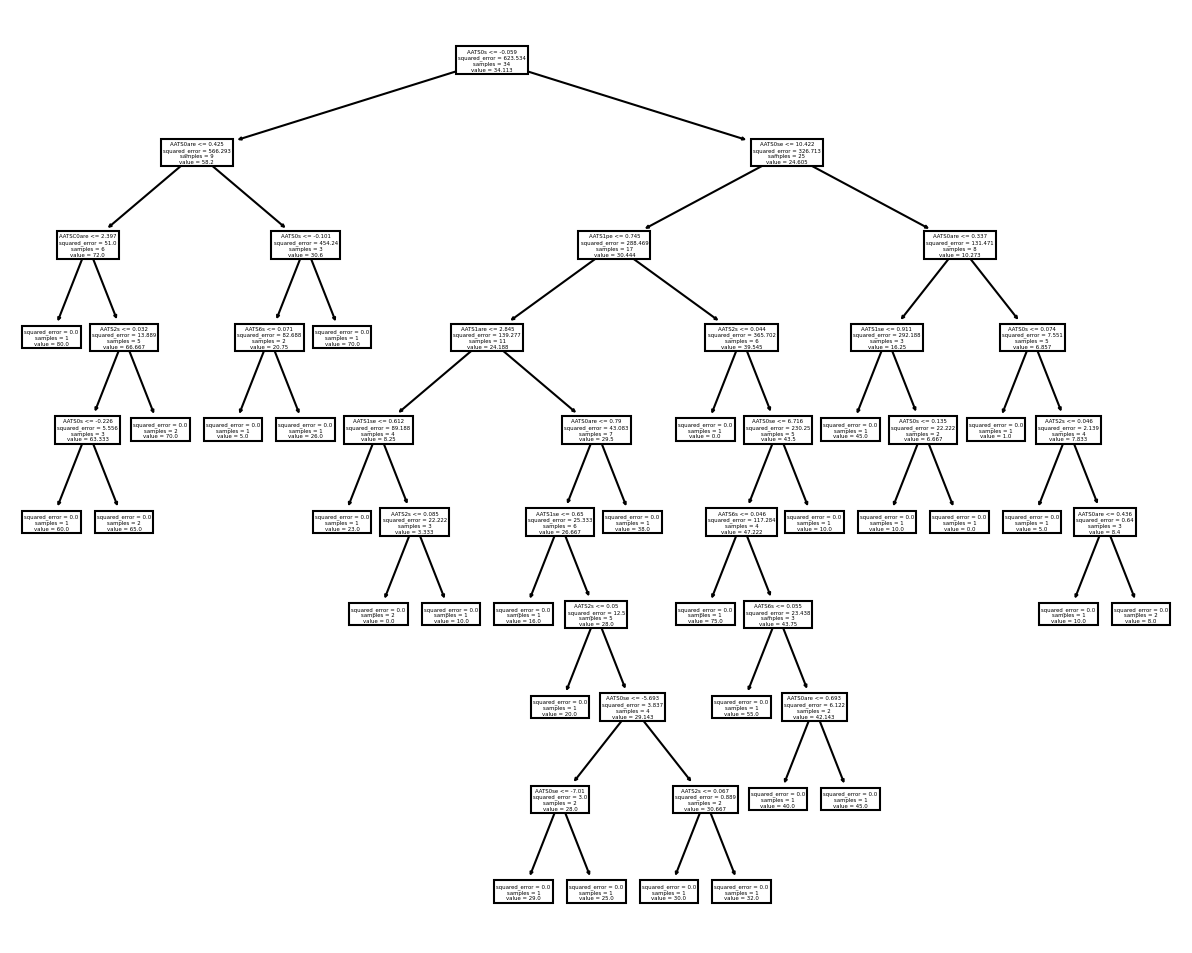

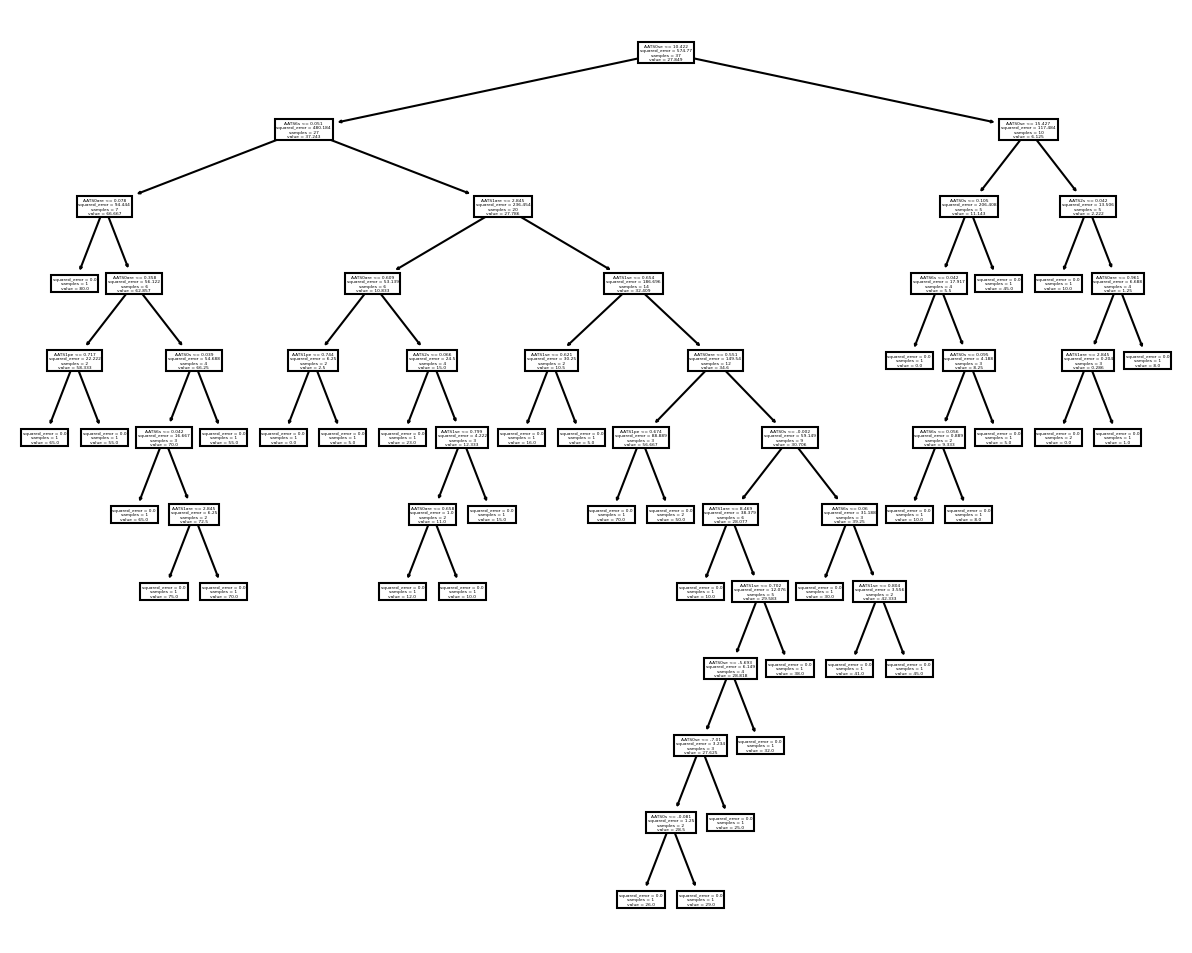

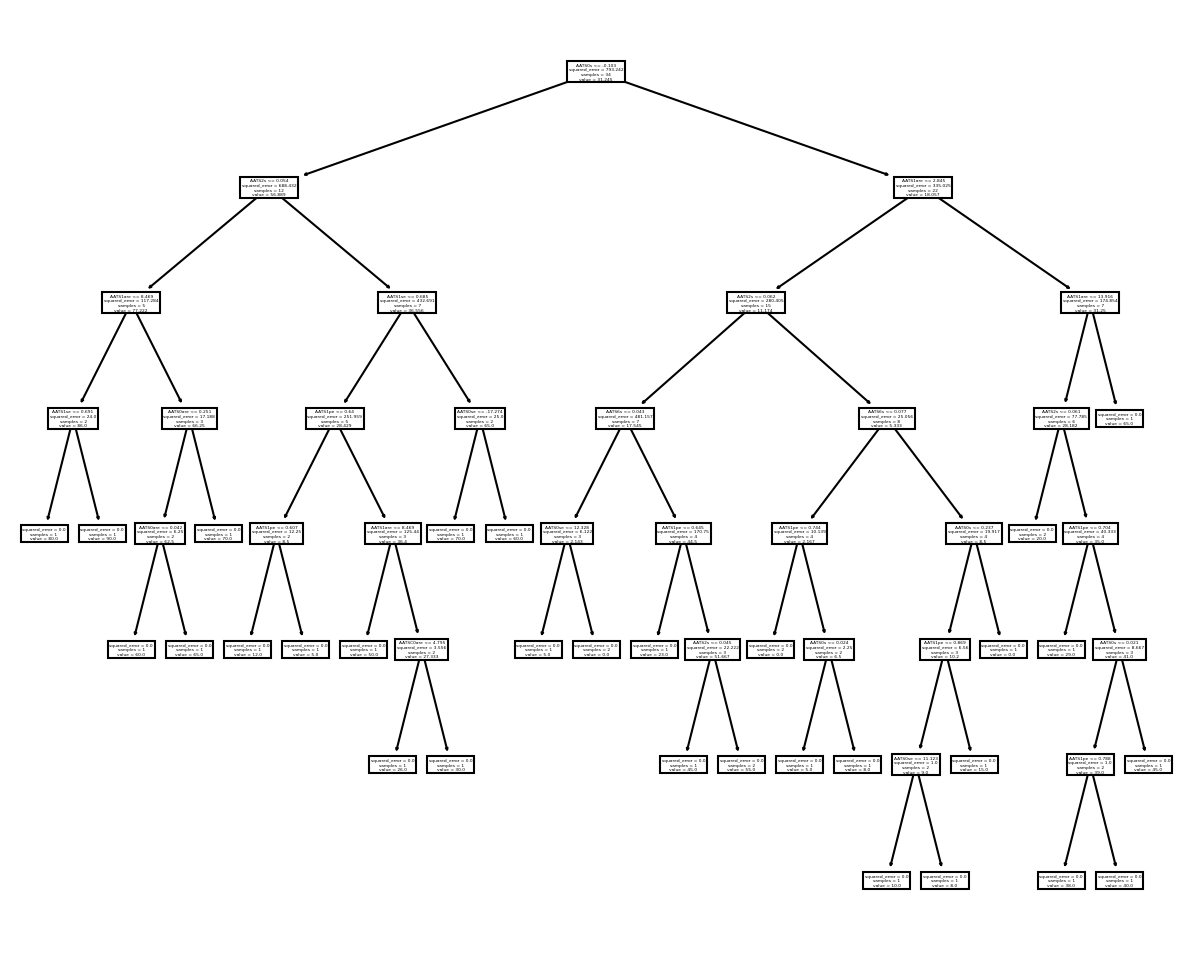

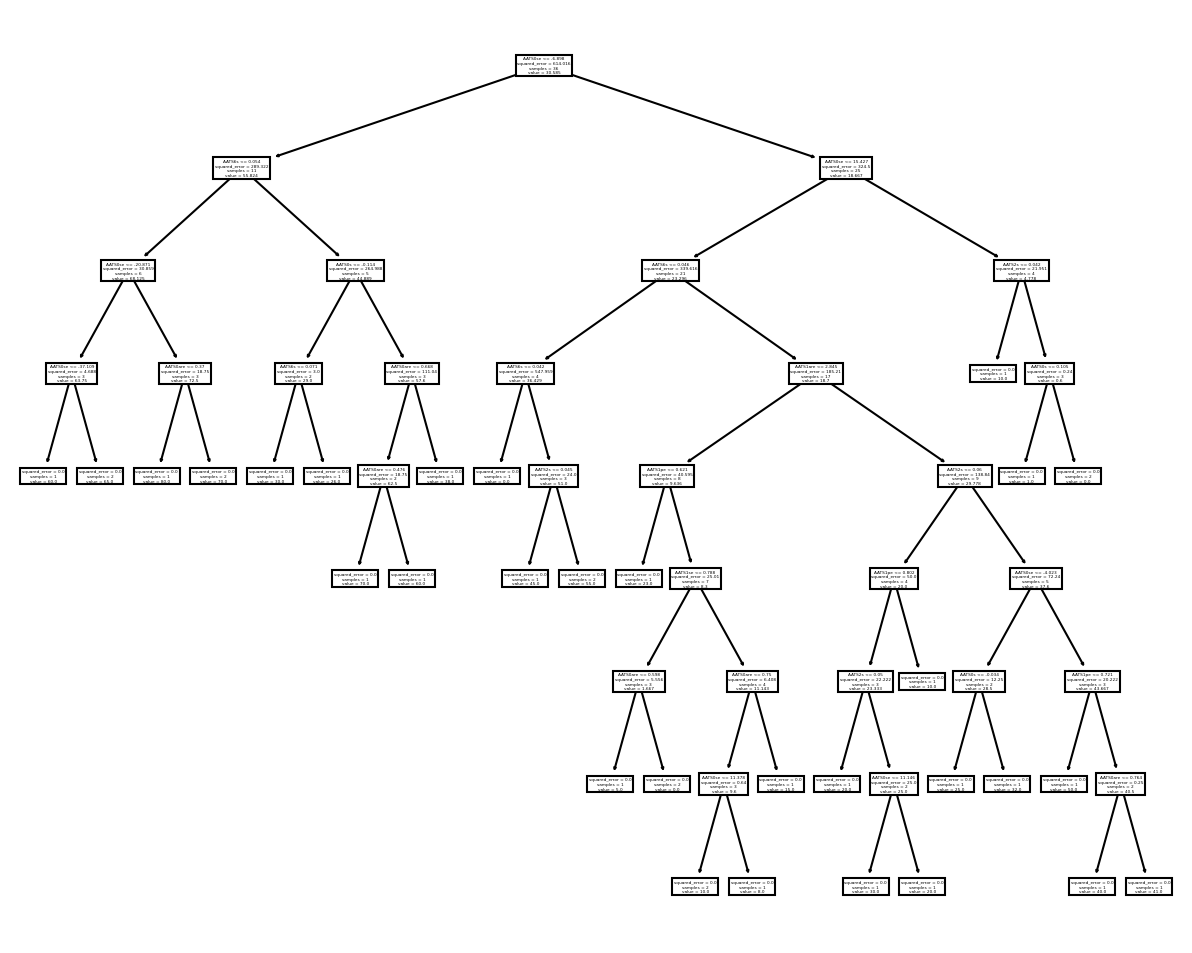

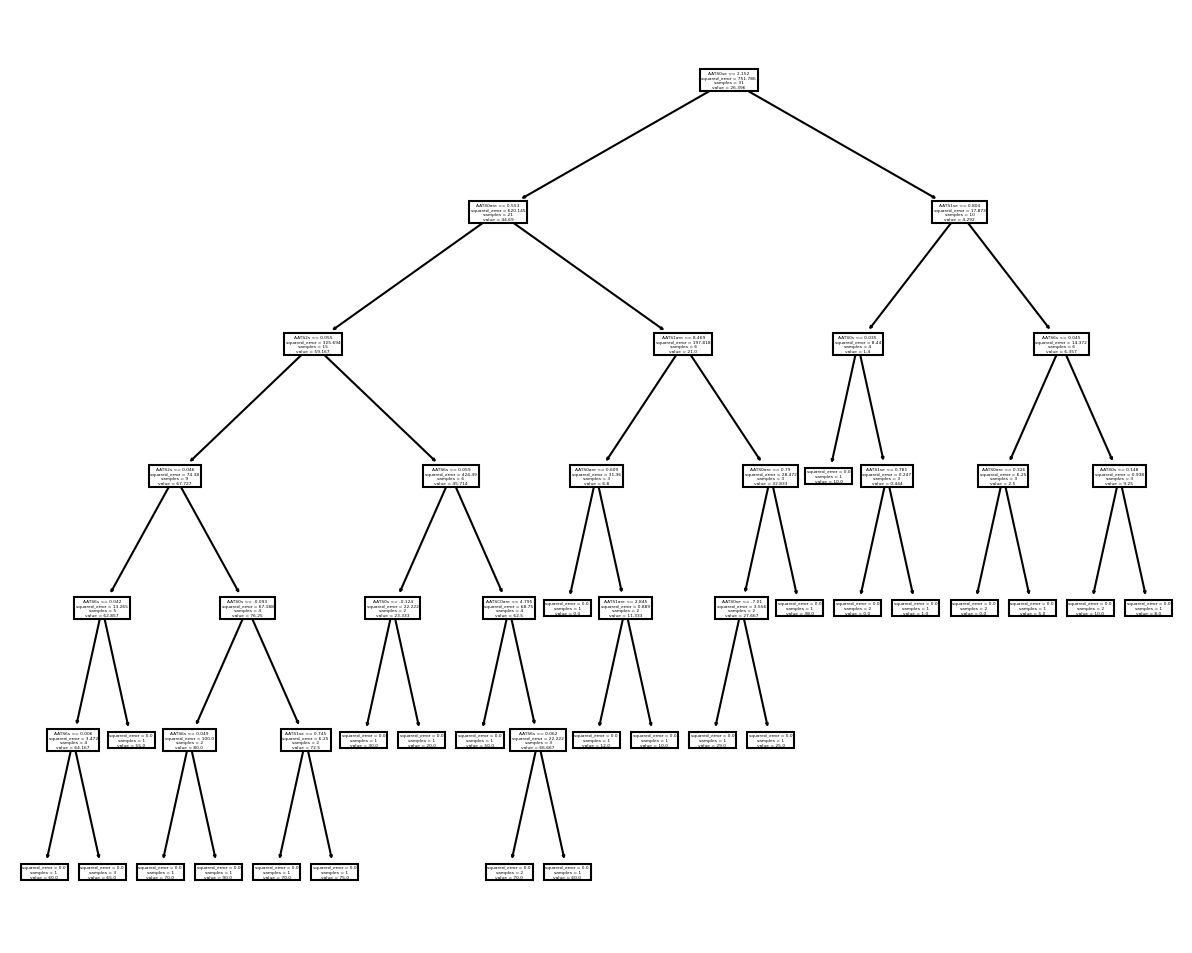

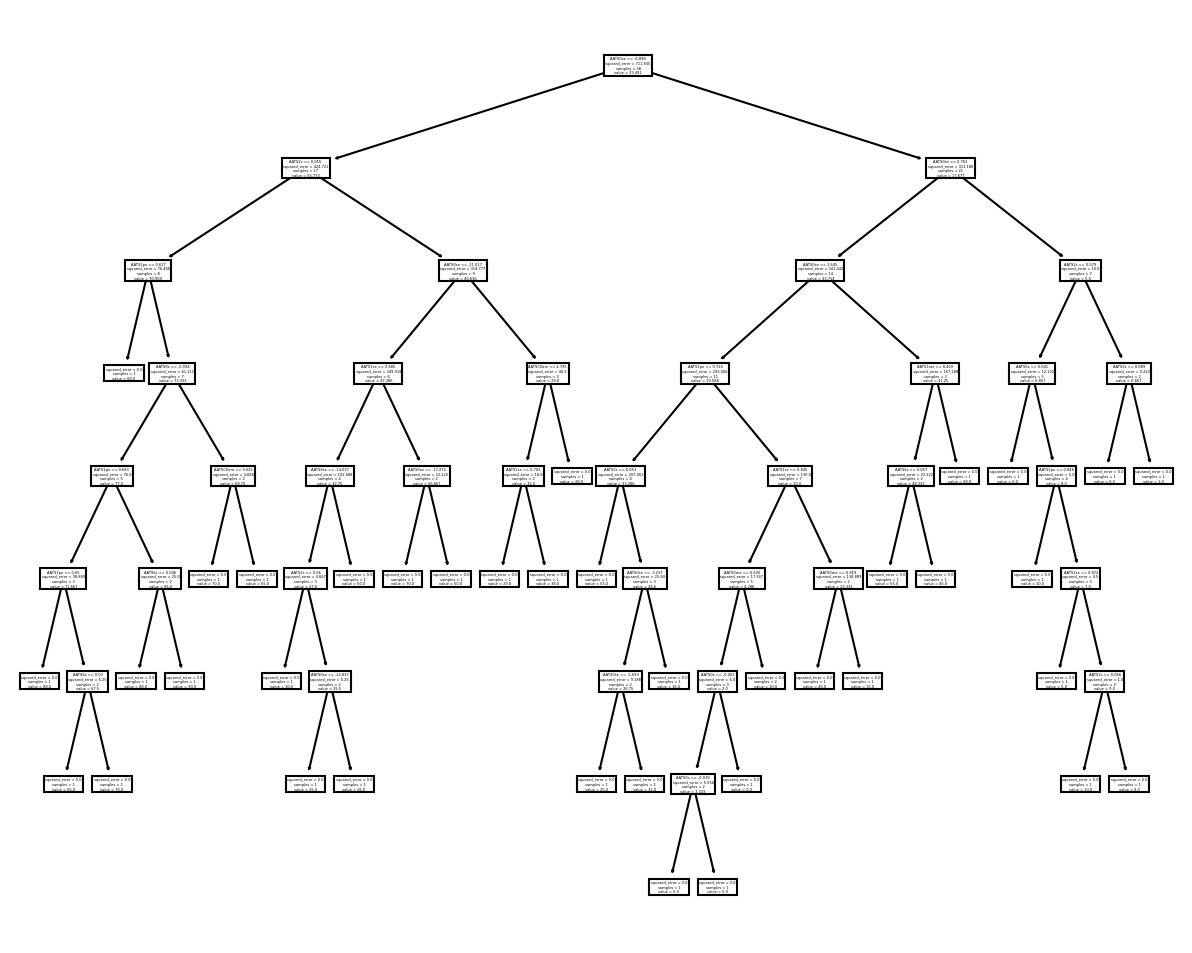

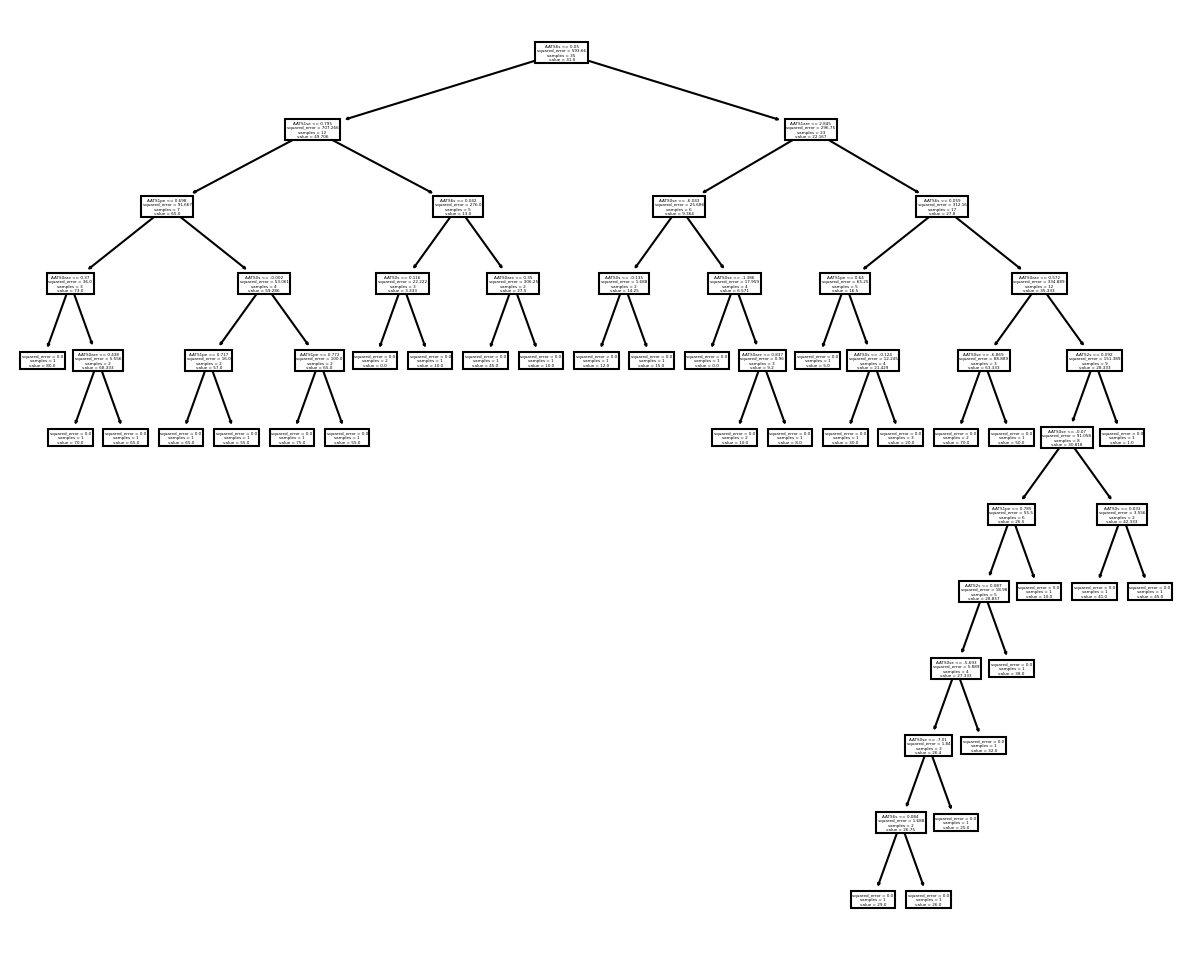

In [40]:
for x, decision_tree in enumerate(final_model[0].estimators_):
    plt.figure(figsize=(10,8), dpi=150)
    plot_tree(decision_tree, feature_names=list(hist2['molecular descriptor name']))
    plt.savefig('Random_forest/random_forest'+str(x)+'.svg')

In [41]:
final_model[4]

,molecular descriptor name,corr_value,absolute correlation value
100,AATSC1Z,-0.435685,0.435685
145,AATSC4s,-0.431682,0.431682
362,ATSC4s,-0.482595,0.482595
476,EState_VSA1,0.444408,0.444408
530,GATS2Z,-0.472027,0.472027
536,GATS2m,-0.450097,0.450097
646,MATS1Z,-0.464299,0.464299
652,MATS1m,-0.462327,0.462327
839,SMR_VSA1,0.446058,0.446058


In [42]:
# save
joblib.dump(final_model[0], "random_forest_model.joblib")
# load, no need to initialize the loaded_rf
loaded_rf = joblib.load("random_forest_model.joblib")

In [44]:
loaded_rf.predict(molecular_descriptors_df[final_model[4]['molecular descriptor name']])

array([15.6 , 49.3 , 52.35, 19.9 , 14.25, 10.05,  8.45,  4.1 , 11.15,
       13.05, 69.5 , 54.25, 61.5 , 45.05, 17.75, 52.75, 37.4 ,  4.25,
       16.5 ,  5.5 ,  9.75, 10.  ,  9.55,  2.2 ,  7.75,  8.7 , 12.05,
       15.75, 45.25, 44.8 , 34.  , 52.3 , 54.1 , 30.25, 61.4 , 46.4 ,
       51.75, 80.75, 71.  , 55.75, 70.5 , 69.5 , 67.  , 22.25, 21.35,
       16.65, 31.7 , 36.65, 21.8 , 21.55, 16.45, 30.  , 32.6 , 38.  ,
       11.65, 27.  , 30.15, 28.15])

In [45]:
molecular_descriptors_df['Aktywność cytoprotekcyjna [%]']

0     12
1     45
2     65
3     15
4     10
5      0
6      8
7      0
8      0
9     90
10    80
11    55
12    75
13    55
14    10
15    50
16    45
17     0
18     5
19     0
20    10
21     0
22    10
23     0
24     5
25    10
26     8
27     5
28    70
29    20
30    25
31    70
32    60
33    30
34    70
35    50
36    70
37    90
38    70
39    60
40    80
41    65
42    65
43    16
44    23
45    10
46    40
47    45
48    20
49    30
50    20
51    26
52    38
53    41
54     1
55    25
56    32
57    29
Name: Aktywność cytoprotekcyjna [%], dtype: int64

In [47]:
xsz = r2_score(loaded_rf.predict(molecular_descriptors_df[final_model[4]['molecular descriptor name']]), molecular_descriptors_df['Aktywność cytoprotekcyjna [%]'])
xsz

0.6140822169531853

In [48]:
np.sqrt(xsz)

0.7836339814946678

## Predict target feature

In [49]:
to_prediction = prepare_data('../Data/Proposed_structures_with_AI_caffeine_tanimoto_similarity_.xlsx')

100%|████████████████████████████████████████████████████████████████████████████████| 383/383 [00:04<00:00, 78.36it/s]


(383, 1613)
(383, 1277)
(383, 1128)


In [50]:
predicted_activity = loaded_rf.predict(to_prediction[final_model[4]['molecular descriptor name']])

In [51]:
smiles = pd.read_excel('../Data/Proposed_structures_with_AI_caffeine_tanimoto_similarity_.xlsx')
smiles = smiles['new_SMILES']
smiles = smiles.to_list()
save_to_df = pd.DataFrame(data=smiles, columns=['SMILES'])

In [52]:
print(len(smiles))
print(len(predicted_activity))

383
383


In [53]:
save_to_df.head()

,SMILES
0,CN1N=C1Sc1ccccc1
1,CN1CCCCCCNCNc2c(n(C)c(=O)n(C)c2=O)N1
2,CNCCC1CCCN(C)Nc2c(c(=O)n(C)c(=O)n2C)N1
3,CN1CCC(CCNC=N)=Nc2c1n(C)c(=O)n(C)c2=O
4,CNCCCCCCN1CC2=C(N1)N(C)C(=O)N(C)C2


In [54]:
save_to_df['Predicted activity'] = predicted_activity

In [55]:
save_to_df.head()

,SMILES,Predicted activity
0,CN1N=C1Sc1ccccc1,19.70
1,CN1CCCCCCNCNc2c(n(C)c(=O)n(C)c2=O)N1,19.85
2,CNCCC1CCCN(C)Nc2c(c(=O)n(C)c(=O)n2C)N1,20.05
3,CN1CCC(CCNC=N)=Nc2c1n(C)c(=O)n(C)c2=O,35.15
4,CNCCCCCCN1CC2=C(N1)N(C)C(=O)N(C)C2,30.50


In [56]:
save_to_df.to_excel('../Data/Predicted_random_forest.xlsx')